In [9]:
import numpy as np
import pennylane as qml
import matplotlib.pyplot as plt

In [3]:
# set the random seed
np.random.seed(42)

# Use the mixed state simulator to save some steps in plotting later
dev = qml.device('default.mixed', wires=1)

In [21]:
@qml.qnode(dev)
def not_a_haar_random_unitary():
    # Sample all parameters from their flat uniform distribution
    phi, theta, omega = 2 * np.pi * np.random.uniform(size=3)
    qml.Rot(phi, theta, omega, wires=0)
    return qml.state()

num_samples = 2000

not_haar_samples = [not_a_haar_random_unitary() for _ in range(num_samples)]

In [22]:
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])

In [23]:
# Used the mixed state simulator so we could have the density matrix for this part!
def convert_to_bloch_vector(rho):
    """Convert a density matrix to a Bloch vector."""
    ax = np.trace(np.dot(rho, X)).real
    ay = np.trace(np.dot(rho, Y)).real
    az = np.trace(np.dot(rho, Z)).real
    return [ax, ay, az]

not_haar_bloch_vectors = np.array([convert_to_bloch_vector(s) for s in not_haar_samples])

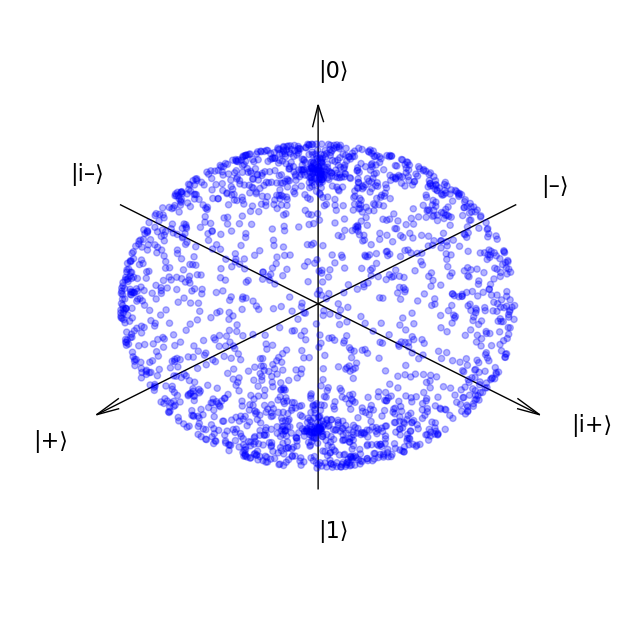

In [24]:
def plot_bloch_sphere(bloch_vectors):
    """ Helper function to plot vectors on a sphere."""
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

    ax.grid(False)
    ax.set_axis_off()
    ax.view_init(30, 45)
    ax.dist = 7

    # Draw the axes (source: https://github.com/matplotlib/matplotlib/issues/13575)
    x, y, z = np.array([[-1.5,0,0], [0,-1.5,0], [0,0,-1.5]])
    u, v, w = np.array([[3,0,0], [0,3,0], [0,0,3]])
    ax.quiver(x, y, z, u, v, w, arrow_length_ratio=0.05, color="black", linewidth=1)

    ax.text(0, 0, 1.7, r"|0⟩", color="black", fontsize=16)
    ax.text(0, 0, -1.9, r"|1⟩", color="black", fontsize=16)
    ax.text(1.9, 0, 0, r"|+⟩", color="black", fontsize=16)
    ax.text(-1.7, 0, 0, r"|–⟩", color="black", fontsize=16)
    ax.text(0, 1.7, 0, r"|i+⟩", color="black", fontsize=16)
    ax.text(0,-1.9, 0, r"|i–⟩", color="black", fontsize=16)

    ax.scatter(
        bloch_vectors[:,0], bloch_vectors[:,1], bloch_vectors[:, 2], c='blue', alpha=0.3
    )

plot_bloch_sphere(not_haar_bloch_vectors)

(array([ 72.,  82.,  53.,  68.,  78.,  93.,  87., 112., 149., 203., 191.,
        141., 102., 112.,  89.,  75.,  74.,  76.,  74.,  69.]),
 array([-0.9973367 , -0.89748707, -0.79763745, -0.69778782, -0.59793819,
        -0.49808857, -0.39823894, -0.29838931, -0.19853969, -0.09869006,
         0.00115956,  0.10100919,  0.20085882,  0.30070844,  0.40055807,
         0.5004077 ,  0.60025732,  0.70010695,  0.79995658,  0.8998062 ,
         0.99965583]),
 <BarContainer object of 20 artists>)

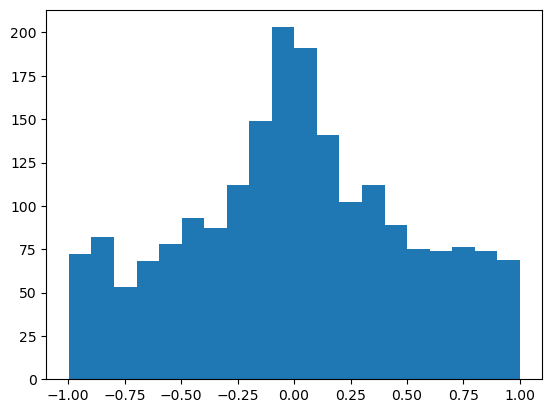

In [37]:
plt.hist(not_haar_bloch_vectors[:,0],20)

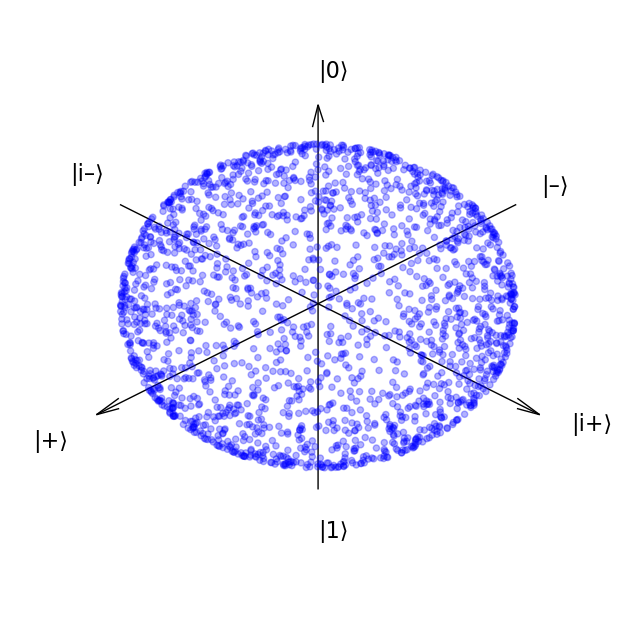

In [38]:
from scipy.stats import rv_continuous

class sin_prob_dist(rv_continuous):
    def _pdf(self, theta):
        # The 0.5 is so that the distribution is normalized
        return 0.5 * np.sin(theta)

# Samples of theta should be drawn from between 0 and pi
sin_sampler = sin_prob_dist(a=0, b=np.pi)

@qml.qnode(dev)
def haar_random_unitary():
    phi, omega = 2 * np.pi * np.random.uniform(size=2) # Sample phi and omega as normal
    theta = sin_sampler.rvs(size=1) # Sample theta from our new distribution
    qml.Rot(phi, theta, omega, wires=0)
    return qml.state()

haar_samples = [haar_random_unitary() for _ in range(num_samples)]
haar_bloch_vectors = np.array([convert_to_bloch_vector(s) for s in haar_samples])

plot_bloch_sphere(haar_bloch_vectors)

(array([103.,  92., 111.,  99.,  93., 100.,  96., 110., 101.,  97., 113.,
         95.,  92., 100., 111.,  86., 101., 108.,  84., 108.]),
 array([-9.99106912e-01, -8.99171540e-01, -7.99236169e-01, -6.99300798e-01,
        -5.99365426e-01, -4.99430055e-01, -3.99494684e-01, -2.99559312e-01,
        -1.99623941e-01, -9.96885698e-02,  2.46801521e-04,  1.00182173e-01,
         2.00117544e-01,  3.00052916e-01,  3.99988287e-01,  4.99923658e-01,
         5.99859029e-01,  6.99794401e-01,  7.99729772e-01,  8.99665143e-01,
         9.99600515e-01]),
 <BarContainer object of 20 artists>)

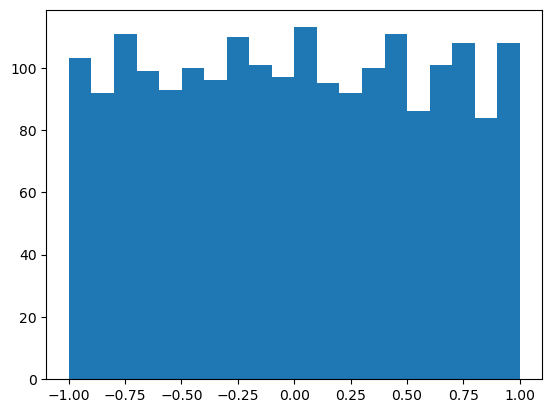

In [44]:
plt.hist(haar_bloch_vectors[:,0],20)

In [45]:
from numpy.linalg import qr

def qr_haar(N):
    """Generate a Haar-random matrix using the QR decomposition."""
    # Step 1
    A, B = np.random.normal(size=(N, N)), np.random.normal(size=(N, N))
    Z = A + 1j * B

    # Step 2
    Q, R = qr(Z)

    # Step 3
    Lambda = np.diag([R[i, i] / np.abs(R[i, i]) for i in range(N)])

    # Step 4
    return np.dot(Q, Lambda)

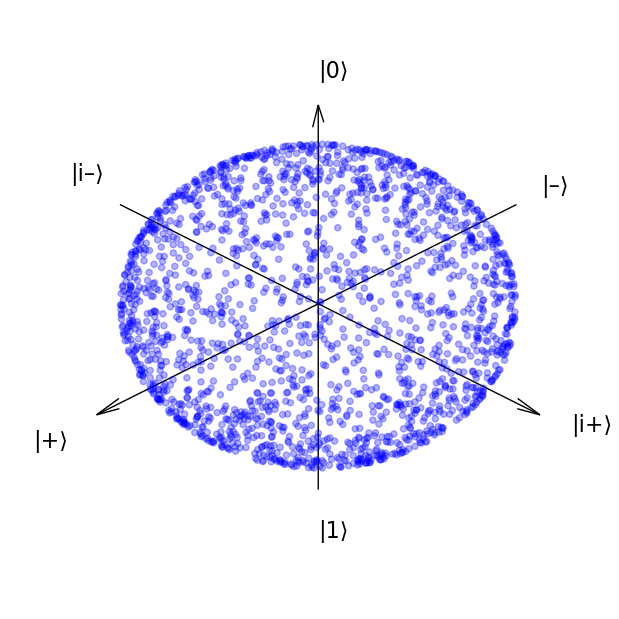

In [46]:
@qml.qnode(dev)
def qr_haar_random_unitary():
    qml.QubitUnitary(qr_haar(2), wires=0)
    return qml.state()

qr_haar_samples = [qr_haar_random_unitary() for _ in range(num_samples)]
qr_haar_bloch_vectors = np.array([convert_to_bloch_vector(s) for s in qr_haar_samples])
plot_bloch_sphere(qr_haar_bloch_vectors)

(array([117., 103., 113.,  86., 114., 100.,  95., 102.,  94., 103.,  82.,
         90., 112., 112.,  97.,  79., 104., 100., 109.,  88.]),
 array([-0.99637882, -0.89657033, -0.79676185, -0.69695337, -0.59714489,
        -0.49733641, -0.39752792, -0.29771944, -0.19791096, -0.09810248,
         0.001706  ,  0.10151449,  0.20132297,  0.30113145,  0.40093993,
         0.50074841,  0.6005569 ,  0.70036538,  0.80017386,  0.89998234,
         0.99979082]),
 <BarContainer object of 20 artists>)

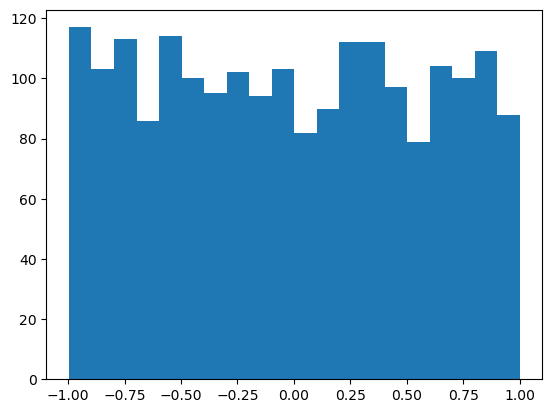

In [50]:
plt.hist(qr_haar_bloch_vectors[:,2],20)